### Test pyro model by using simulations

### simulation without mixture modelling

In [1]:
import pyro.distributions as dist
from pyro.distributions.torch_distribution import TorchDistribution
from tissue_purifier.genex.pyro_model import *
from tissue_purifier.genex.gene_utils import *

import numpy
import numpy as np
import torch
import seaborn
import tarfile
import os
import matplotlib
import matplotlib.pyplot as plt
from anndata import read_h5ad
import scanpy as sc
import pandas as pd


/home/jupyter/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
### draw beta coefficients for 10 cell types and 100 genes from normal(0,1) distribution
### draw epsilon coefficients for 100 genes from normal(0,0.1)
### draw ncv's for 1000 spots/cells from dirichlet distribution
### draw mixture coefficients for 1000 spots/cells from dirichlet distribution
### nUmis from log-normal centered around 300
### lambdas from laplace distribution (100 genes x 10 ncv)

k = 10
n = 10000
g = 100
l = 10 # same as k b/c ncv

beta0_k1g = dist.Normal(-5, 1).sample((k,g))[:, None, :]
eps_1g = torch.abs(dist.Normal(0,0.1).sample((1,g)))
prob = np.array([0.8])
ncv_n1l = dist.Dirichlet(torch.tensor(np.repeat(prob,[k]))).sample((n,1))
ncv_nl = ncv_n1l.squeeze()

#mixtures = dist.Dirichlet(torch.tensor(np.repeat(prob,[10]))).sample((1000,1))
lambda_klg = dist.Normal(0, 2.0).sample((k,l,g))
lambda_sparsity = 0.95
lambda_klg.view(-1)[dist.Bernoulli(probs=lambda_sparsity).sample((k,l,g)).bool().view(-1)] = 0.

total_umi_n1 = (300 * dist.LogNormal(0,0.1).sample((n,1))).int().float()

### get 1000 random cell types
cell_ids_n = (torch.rand((n))*k).int().long() ##randint instead

beta0_n1g = beta0_k1g[cell_ids_n]
lambda_nlg = lambda_klg[cell_ids_n]
total_umi_n11 = total_umi_n1[..., None]



covariate_nl1 = ncv_nl.unsqueeze(dim=-1)

log_mu_n1g = beta0_n1g + \
                 torch.sum(covariate_nl1 * lambda_nlg, dim=-2, keepdim=True)

### simulate gene counts for these 1000 spots and 100 genes

eps_n1g = eps_1g.expand(n,1,g)
sim_counts_n1g = LogNormalPoisson(n_trials=total_umi_n11,
                             log_rate=log_mu_n1g,
                             noise_scale=eps_n1g,
                             num_quad_points=8).sample()

sim_counts_baseline_n1g = LogNormalPoisson(n_trials=total_umi_n11,
                             log_rate=beta0_n1g,
                             noise_scale=eps_n1g,
                             num_quad_points=8).sample()

print(sim_counts_n1g.shape)
                              
# pyro.sample("counts",
#             LogNormalPoisson(n_trials=total_umi_n11,
#                              log_rate=log_mu_n1g,
#                              noise_scale=eps_n1g,
#                              num_quad_points=8),
#             obs=counts_ng[ind_n.cpu(), None].index_select(dim=-1, index=ind_g.cpu()).to(device))


### run through tissue_purifier pipeline and see if the correct coefficients are learned back

torch.Size([10000, 1, 100])


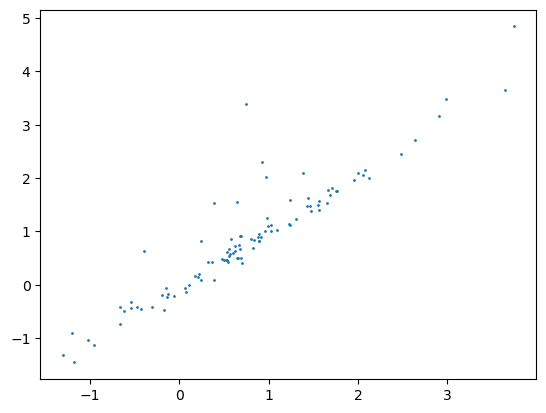

In [6]:
# how much spatial variance do we have?
cell_type = 3
n_mask = cell_ids_n == cell_type

# variance without covariates
var_baseline_g = torch.var(sim_counts_baseline_n1g[n_mask], 0)

# variance with covariates
var_with_cov_g = torch.var(sim_counts_n1g[n_mask], 0)

plt.scatter(var_baseline_g.log(), var_with_cov_g.log(), s=1)

/tmp/ipykernel_7777/652088365.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sim_anndata = anndata.AnnData(X=sparse.csr_matrix(counts))
/home/jupyter/tissue_purifier/src/tissue_purifier/genex/gene_utils.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  covariates_nl_raw = torch.tensor(anndata.obsm[covariate_key])


training from scratch
[iter 1]  loss: 2499416.8091
[iter 500]  loss: 1895784.4746
[iter 1000]  loss: 1859240.0488
[iter 1500]  loss: 1514889.0792
[iter 2000]  loss: 1493223.1758
[iter 2500]  loss: 1371728.5352
[iter 3000]  loss: 1474575.6372
[iter 3500]  loss: 1392995.0786
[iter 4000]  loss: 1447155.3452
[iter 4500]  loss: 1372788.2031
[iter 5000]  loss: 1441439.6270
[iter 5500]  loss: 1372009.8110
[iter 6000]  loss: 1355958.2437
[iter 6500]  loss: 1408260.7069
[iter 7000]  loss: 1448270.3527
[iter 7500]  loss: 1434266.1345
[iter 8000]  loss: 1432683.8283
[iter 8500]  loss: 1385029.8228
[iter 9000]  loss: 1363189.3845
[iter 9500]  loss: 1382939.9087
[iter 10000]  loss: 1484870.3086
Training completed in 97.75773286819458 seconds


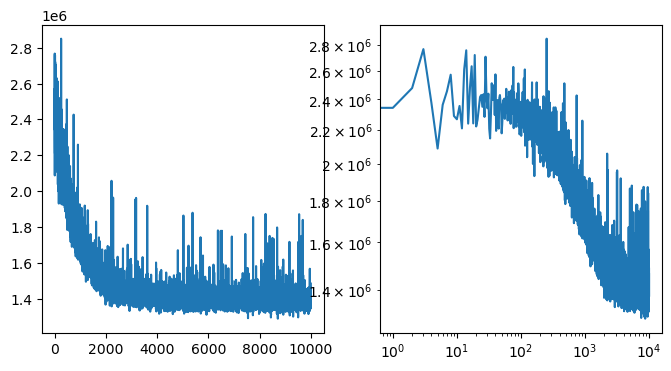

In [7]:
## Create GeneDataset

import anndata
from scipy import sparse

counts = sim_counts_n1g.squeeze()
sim_anndata = anndata.AnnData(X=sparse.csr_matrix(counts))
sim_anndata.obsm['ncv'] = ncv_nl
sim_anndata.obs['cell_type'] = cell_ids_n

## Run GLM

gene_dataset = make_gene_dataset_from_anndata(
        anndata=sim_anndata,
        cell_type_key='cell_type',
        covariate_key='ncv',
        preprocess_strategy='raw',
        apply_pca=False)

train_dataset, test_dataset, val_dataset = next(iter(train_test_val_split(gene_dataset, random_state=0, train_size=0.8,test_size=0.19,val_size=0.01)))

torch.cuda.empty_cache()
gr = GeneRegression()
gr.configure_optimizer(optimizer_type='adam', lr=5e-4)
gr.train(
    dataset=train_dataset,
    n_steps=10000,
    print_frequency=500,
    use_covariates=True,
    l1_regularization_strength=10.,
    l2_regularization_strength=None,
    eps_range=(1.0E-5, 1.0E-4),  # <-- note the upper bound was decreased
    subsample_size_cells=None,
    subsample_size_genes=None,
    initialization_type="scratch")

fig, axes = plt.subplots(ncols=2, figsize=(8,4))
gr.show_loss(ax=axes[0])
gr.show_loss(ax=axes[1], logy=True, logx=True)

In [15]:
## Get fit parameters
pred_eps_k1g = pyro.get_param_store().get_param("eps").float().cpu()
pred_beta0_k1g = pyro.get_param_store().get_param("beta0").float().cpu()
pred_beta_klg = pyro.get_param_store().get_param("beta").float().cpu()

In [16]:
print(eps_n1g.shape)
print(pred_eps_1g.shape)

torch.Size([10000, 1, 100])
torch.Size([10, 1, 100])


In [17]:
## Look at correlation of predicted parameteres to true parameters

## eps correlation
print("eps correlation:")
eps_k1g = eps_1g.expand(k,1,g)
print(np.corrcoef(eps_k1g.detach().numpy().flatten(), pred_eps_1g.detach().numpy().flatten())[0,1])

## beta 0 correlation
print("beta0 correlation:")
print(np.corrcoef(beta0_k1g.detach().numpy().flatten(), pred_beta0_k1g.detach().numpy().flatten())[0,1])

## beta correlation
print("beta correlation:")
print(np.corrcoef(lambda_klg.detach().numpy().flatten(), pred_beta_klg.detach().numpy().flatten())[0,1])

eps correlation:
0.16244240329807771
beta0 correlation:
0.9502745156652437
beta correlation:
0.032831085252687596


In [18]:
lambda_nnz = lambda_klg[(lambda_klg > 0)]
pred_beta_nnz = pred_beta_klg[(lambda_klg > 0)]

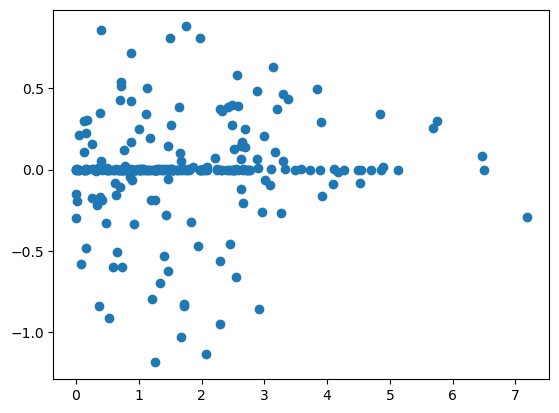

In [19]:
plt.scatter(lambda_nnz.detach().cpu().numpy(), pred_beta_nnz.detach().cpu().numpy())